In [2]:
import hypertools as hyp
import seaborn as sns
from datetime import datetime

import numpy as np 
import pandas as pd

from pylab import plot, show, figure, imshow
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from __future__ import division

import os

import pickle

from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor




/homes/mamr3/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
#Constant Variables python
# kGroup = sys.argv[1]
# kInstrument = sys.argv[1]
# kSampleRate = 44100
# kN = 100
# kType = 'mono'
# kFeatures = 1812 #Find a way to not hard-code this.     
# path = './Music/Data/MedleyDB/Features/%s/%s/' % (sys.argv[2], kType)


#Constant Variables Jupyter
kGroup = 'tack piano'
kInstrument = 'tack piano'
kSampleRate = 44100
kN = 100 #Number of features to take into account initially.
kType = 'mono'
kFeatures = 1812 #Find a way to not hard-code this.     
path = './Music/Data/MedleyDB/Features/Analysis/'



def dumpPickle(d, name, _path = path):
#  path = './Music/Data/MedleyDB/Features/z_Arrays/%s/' % (kType)

  with open(_path + name, 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(d, output)
    
  print '%s Saved' % (name)
  
def loadPickle(name,_path = path):  
#  path = './Music/Data/MedleyDB/Features/z_Arrays/%s/' % (kType)
  # load data from pkl file
  with open(_path + name, "rb") as fp:
      loaded_data1 = pickle.load(fp)
  
  print '%s loaded, %s ' % (name, type(loaded_data1))
  
  return loaded_data1

def plotOOBError(error, xlabel = 'n_features', ylabel = 'OOB error rate'):
    _x = []
    _y = []
    %matplotlib notebook
    
    for tupla in error:
        _x.append(tupla[0])
        _y.append(tupla[1])
    plt.rcParams['figure.figsize'] = (10,10)    
    plt.plot(_x, _y, 'ko')
    
    plt.xlim(np.min(_x), np.max(_x)+100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="upper right")
    #plt.show()
    
def plotVTscore(Vscore1, Vstd1, Vscore2, Vstd2, Tscore1, Tscore2, nFeatures, instrument):   

    %matplotlib notebook
    n_groups = 3

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.1

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(index, Vscore1, bar_width,
                     alpha=opacity*2,
                     color='b',
                     yerr=Vstd1,
                     error_kw=error_config,
                     label='Validation error - %d Features' % nFeatures)

    

    rects3 = plt.bar(index + bar_width, Tscore1, bar_width,
                     alpha=opacity*2,
                     color='r',
                     label='Test error - %d Features' % nFeatures)
    
    rects2 = plt.bar(index + 2*bar_width +0.1, Vscore2, bar_width,
                     alpha=opacity,
                     color='b',
                     yerr=Vstd2,
                     error_kw=error_config,
                     label='Validation error - 3236 Features')

    rects4 = plt.bar(index + 3*bar_width +0.1, Tscore2, bar_width,
                     alpha=opacity,
                     color='r',
                     label='Test error - 3236 Features')

    plt.xlabel('Classifier')
    plt.ylabel('R^2 Score')
    plt.title('R^score Validation and Test - %s' %(instrument))
    plt.xticks(index + 4*bar_width / 2+0.05, ('RF','SV','LG'))
    plt.legend()

    plt.tight_layout()
    #plt.show()

In [4]:
#%%
#Only if you initialized Variables.

X = loadPickle('X.pkl')
y = loadPickle('y.pkl')
gNameFeatures = loadPickle('gNameFeatures.pkl')
gPreSelectedFeatures = loadPickle('gPreSelectedFeatures.pkl')


gInterpretationFeatures= loadPickle('gInterpretationFeatures.pkl', _path = path)
gInterpretationIdx= loadPickle('gInterpretationIdx.pkl', _path = path)
gInterpretationOOBError= loadPickle('gIntepretationOOB.pkl', _path = path)

gPrePredictionOOBError= loadPickle('gPrePredictionOOBError.pkl', _path = path)

gPredictionIdx= loadPickle('gPredictionIdx.pkl', _path = path)
gPredictionOOBError= loadPickle('gPredictionOOBError.pkl', _path = path)
gPredictionOOBErrorGain= loadPickle('gPredictionOOBErrorGain.pkl', _path = path)

gPredictionFeatures = loadPickle('gPredictionFeatures.pkl')





X.pkl loaded, <class 'collections.OrderedDict'> 
y.pkl loaded, <class 'collections.OrderedDict'> 
gNameFeatures.pkl loaded, <class 'collections.OrderedDict'> 
gPreSelectedFeatures.pkl loaded, <class 'collections.OrderedDict'> 
gInterpretationFeatures.pkl loaded, <class 'collections.OrderedDict'> 
gInterpretationIdx.pkl loaded, <class 'collections.OrderedDict'> 
gIntepretationOOB.pkl loaded, <class 'collections.OrderedDict'> 
gPrePredictionOOBError.pkl loaded, <class 'collections.OrderedDict'> 
gPredictionIdx.pkl loaded, <class 'collections.OrderedDict'> 
gPredictionOOBError.pkl loaded, <class 'collections.OrderedDict'> 
gPredictionOOBErrorGain.pkl loaded, <class 'collections.OrderedDict'> 
gPredictionFeatures.pkl loaded, <class 'collections.OrderedDict'> 


In [5]:
kInstruments = ['bass3', 'guitar5', 'vocal2', 'keys-all3']

In [6]:
#Gets dataframes of Prediction Features.

XPrediction = OrderedDict()
GPredictionFeatures = OrderedDict()
for k in kInstruments:
    #print '\n %s \n' % k.upper()        
    _A = X[k][:]
    label = y[k]
    Xpreselected = [] 
    for i in gPredictionIdx[k]:

        Xpreselected.append(_A[:,i])
        
    XPrediction[k] = np.asarray(Xpreselected).T 
    
    x = []
    for f in gPredictionFeatures[k]:
        x.append('.'.join(f.split('.')[1::]))
    GPredictionFeatures[k] = x

dfBass_P = pd.DataFrame(XPrediction[kInstruments[0]], columns = GPredictionFeatures[kInstruments[0]])
dfGuitar_P = pd.DataFrame(XPrediction[kInstruments[1]], columns = GPredictionFeatures[kInstruments[1]])
dfVocal_P = pd.DataFrame(XPrediction[kInstruments[2]], columns = GPredictionFeatures[kInstruments[2]])
dfKeys_P = pd.DataFrame(XPrediction[kInstruments[3]], columns = GPredictionFeatures[kInstruments[3]])

<IPython.core.display.Javascript object>


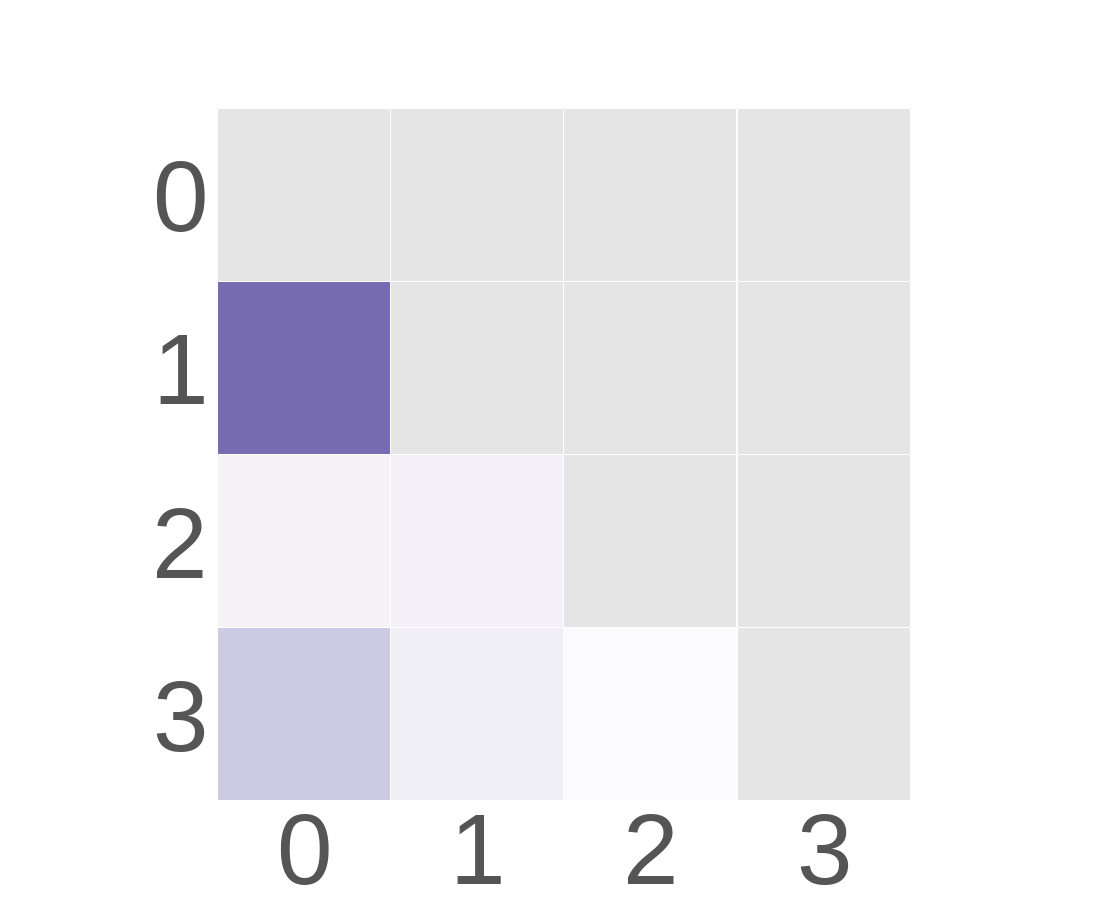

<IPython.core.display.Javascript object>


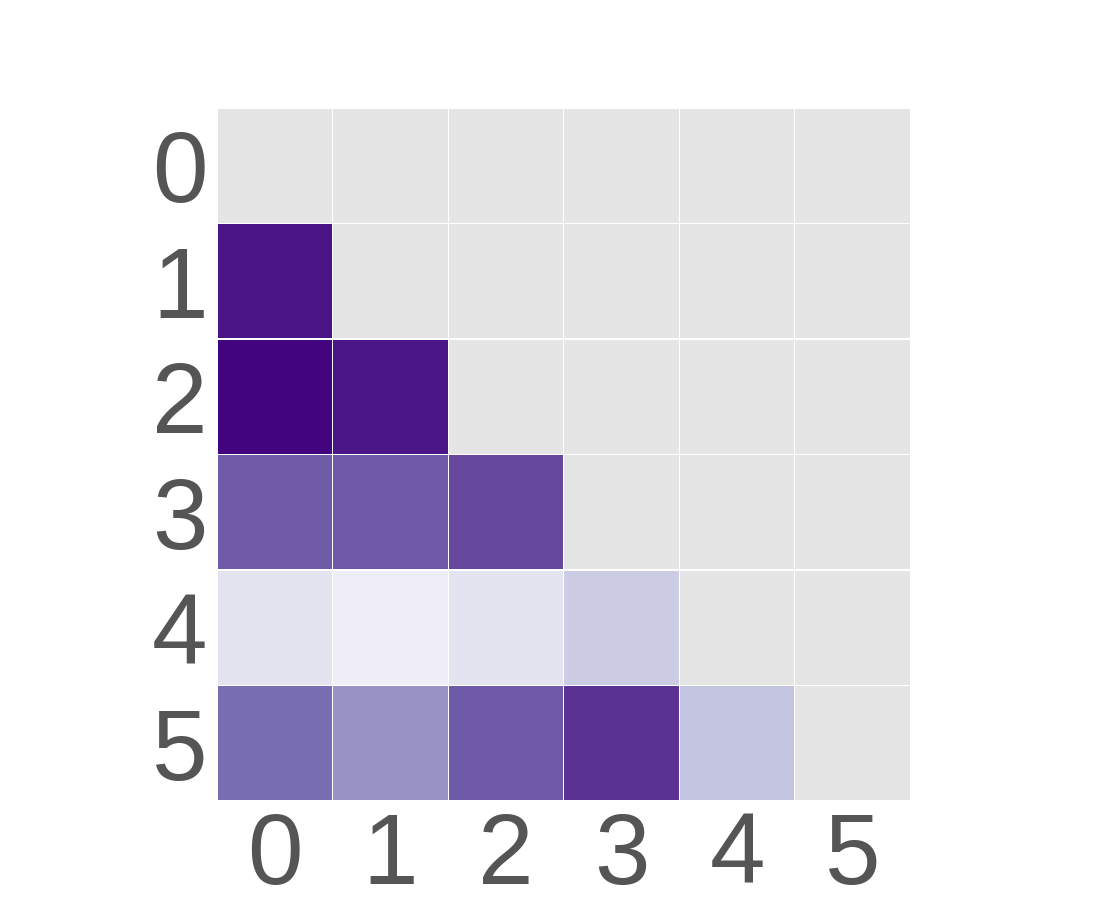

<IPython.core.display.Javascript object>


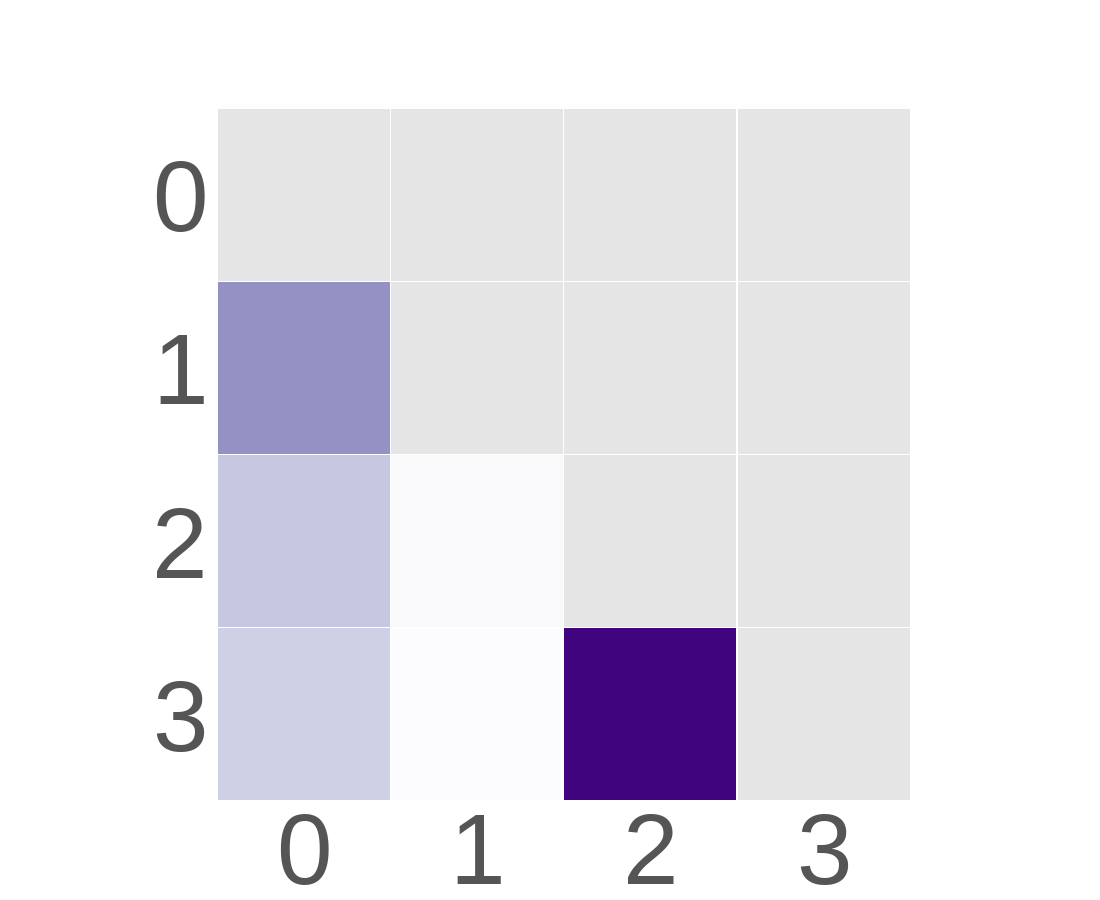

<IPython.core.display.Javascript object>


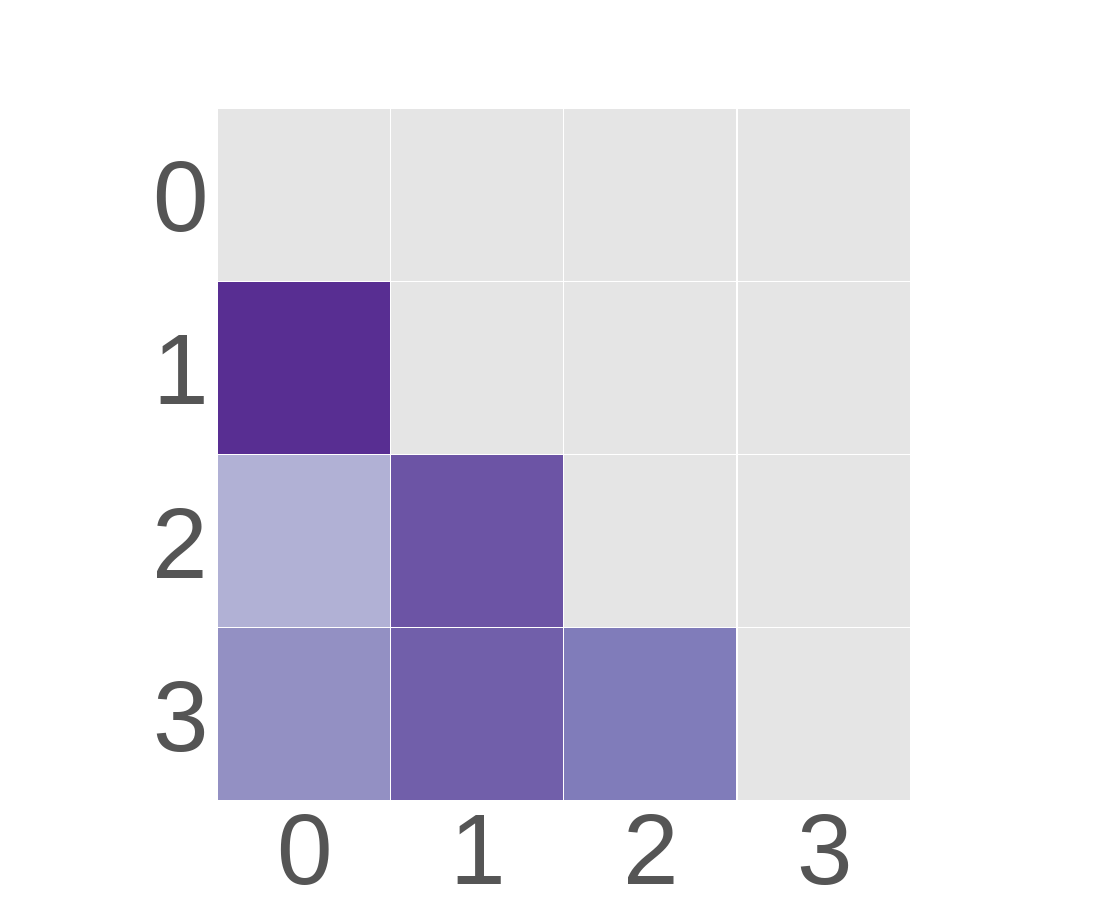

In [27]:

def plotCorr(df, instrument):
    df_norm = (df - df.mean()) / (df.max() - df.min())
    # Compute the correlation matrix
    corr = df_norm.corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='Purples', vmax=1, vmin=0,
                square=True, 
                linewidths=.1, cbar=None,
                ax=ax)
    #plt.title('Correlation map - %s features' % instrument)
    ax.set_xticklabels(np.arange(len(df.columns)), rotation=0,fontsize = 72)
    ax.set_yticklabels(np.arange(len(df.columns))[::-1], rotation=0, fontsize = 72)
    f.savefig('%s-corr.png'%instrument, format='PNG', transparent = False, dpi=600)
    #plt.xticks(fontsize = 46)
    #plt.yticks(fontsize = 46)
plotCorr(dfBass_P, 'bass')
plotCorr(dfGuitar_P, 'guitar')
plotCorr(dfVocal_P, 'vocal')
plotCorr(dfKeys_P, 'keys')

In [7]:
#Gets dataframes of Interpretation Features.
XInterpretation = OrderedDict()
GInterpretationFeatures = OrderedDict()
for k in kInstruments:
    #print '\n %s \n' % k.upper()        
    _A = X[k][:]
    label = y[k]
    Xpreselected = [] 
    for i in gInterpretationIdx[k][0:len(gInterpretationFeatures[k])]:

        Xpreselected.append(_A[:,i])
        
    XInterpretation[k] = np.asarray(Xpreselected).T 
    
    x = []
    for f in gInterpretationFeatures[k]:
        x.append('.'.join(f.split('.')[1::]))
    GInterpretationFeatures[k] = x

dfBass_I = pd.DataFrame(XInterpretation[kInstruments[0]], columns = GInterpretationFeatures[kInstruments[0]])
dfGuitar_I = pd.DataFrame(XInterpretation[kInstruments[1]], columns = GInterpretationFeatures[kInstruments[1]])
dfVocal_I = pd.DataFrame(XInterpretation[kInstruments[2]], columns = GInterpretationFeatures[kInstruments[2]])
dfKeys_I = pd.DataFrame(XInterpretation[kInstruments[3]], columns = GInterpretationFeatures[kInstruments[3]])



In [8]:
#Gets dataframes of Preselected Features.
XPreSelected = OrderedDict()
GPreSelectedFeatures = OrderedDict()
for k in kInstruments:
    #print '\n %s \n' % k.upper()        
    _A = X[k][:]
    label = y[k]
    Xpreselected = [] 
    for i in gInterpretationIdx[k]:

        Xpreselected.append(_A[:,i])
        
    XPreSelected[k] = np.asarray(Xpreselected).T 
    
    x = []
    for f in gPreSelectedFeatures[k]:
        x.append('.'.join(f.split('.')[1::]))
    GPreSelectedFeatures[k] = x

dfBass_Pre = pd.DataFrame(XPreSelected[kInstruments[0]], columns = GPreSelectedFeatures[kInstruments[0]])
dfGuitar_Pre = pd.DataFrame(XPreSelected[kInstruments[1]], columns = GPreSelectedFeatures[kInstruments[1]])
dfVocal_Pre = pd.DataFrame(XPreSelected[kInstruments[2]], columns = GPreSelectedFeatures[kInstruments[2]])
dfKeys_Pre = pd.DataFrame(XPreSelected[kInstruments[3]], columns = GPreSelectedFeatures[kInstruments[3]])


In [9]:
#Gets dataframes of All Features.
XAll= OrderedDict()
GPreSelectedFeatures = OrderedDict()
for k in kInstruments:
    #print '\n %s \n' % k.upper()        
    XAll[k] = X[k][:]
    label = y[k]
    
    

dfBass_All = pd.DataFrame(XAll[kInstruments[0]])
dfGuitar_All = pd.DataFrame(XAll[kInstruments[1]])
dfVocal_All = pd.DataFrame(XAll[kInstruments[2]])
dfKeys_All = pd.DataFrame(XAll[kInstruments[3]])


In [ ]:
#Quantitative analysis:   
#%%

#Random Forest Classifier

def RandomForestC(data):
    for k in kInstruments:
        A = data[k][:]

        startTime = datetime.now() 

        #quantitative testing with a RF classifier, score is summaried over N epoch
        _Vscore = []
        epoch = 10                                        
        X_train, X_test, y_train, y_test = train_test_split(A, y[k],
                                                           train_size=0.8,
                                                           random_state=None)

        for i in range(epoch):

            #    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train,
            #                                                    train_size=0.8,
            #                                                    random_state=None)
            forest = RandomForestClassifier(n_estimators=2000, warm_start=False,
                                               oob_score=False, max_features=0.3, random_state=None)
            kfold = KFold(n_splits=5)

            for train, test in kfold.split(X_train):

                forest.fit(X_train[train], y_train[train])
                _Vscore.append(forest.score(X_train[test], y_train[test]))   
        print '\n %s - RF Validation R2 score mean: %f \n' % (k, np.mean(_Vscore))      
        print '\n %s - RF Validation R2 score std: %f \n' % (k, np.std(_Vscore))
        print '\n %s - RF Test R2 score: %f \n' % (k, forest.score(X_test, y_test))    
        print '\nExecuted in: %s. \n ' % (str(datetime.now() - startTime))  



In [ ]:
#SVC
def SupportVectorC(data):
    for k in kInstruments:
        A = data[k][:]

        startTime = datetime.now() 

        #quantitative testing with a RF classifier, score is summaried over N epoch
        _Vscore = []
        epoch = 100                                       
        X_train, X_test, y_train, y_test = train_test_split(A, y[k],
                                                           train_size=0.8,
                                                           random_state=None)

        for i in range(epoch):

            svc = SVC(kernel='rbf', C=1, gamma='auto')
            kfold = KFold(n_splits=5)

            for train, test in kfold.split(X_train):

                svc.fit(X_train[train], y_train[train])
                _Vscore.append(svc.score(X_train[test], y_train[test]))
        print '\n %s - SVC Validation R2 score mean: %f \n' % (k, np.mean(_Vscore))      
        print '\n %s - SVC Validation R2 score std: %f \n' % (k, np.std(_Vscore))
        print '\n %s - SVC Test R2 score: %f \n' % (k, svc.score(X_test, y_test))  
        
        
        print '\nExecuted in: %s. \n ' % (str(datetime.now() - startTime))  

In [ ]:
#LGC
def LogisticRegressionC(data):
    for k in kInstruments:
        A = data[k][:]
        startTime = datetime.now() 

        #quantitative testing with a RF classifier, score is summaried over N epoch
        _Vscore = []
        epoch = 100                                       
        X_train, X_test, y_train, y_test = train_test_split(A, y[k],
                                                           train_size=0.8,
                                                           random_state=None)

        for i in range(epoch):

            clf = LogisticRegression(C=1,  tol=0.01)
            
            kfold = KFold(n_splits=5)

            for train, test in kfold.split(X_train):

                clf.fit(X_train[train], y_train[train])
                _Vscore.append(clf.score(X_train[test], y_train[test]))

        print '\n %s - LG Validation R2 score mean: %f \n' % (k, np.mean(_Vscore))      
        print '\n %s - LG Validation R2 score std: %f \n' % (k, np.std(_Vscore))
        print '\n %s - LG Test R2 score: %f \n' % (k, clf.score(X_test, y_test))    
        print '\nExecuted in: %s. \n ' % (str(datetime.now() - startTime))   


In [ ]:
print '\n Prediction RFC: \n'
RandomForestC(XPrediction)
print '\n Interpretation RFC: \n'
RandomForestC(XInterpretation)
print '\n Preselected RFC: \n'
RandomForestC(XPreSelected)
print '\n All RFC: \n'
RandomForestC(XAll)





In [ ]:
print '\n Prediction SVC: \n'
SupportVectorC(XPrediction)
print '\n Interpretation SVC: \n'
SupportVectorC(XInterpretation)
print '\n Preselected SVC: \n'
SupportVectorC(XPreSelected)
print '\n All SVC: \n'
SupportVectorC(XAll)




In [ ]:
print '\n Prediction LG: \n'
LogisticRegressionC(XPrediction)
print '\n Interpretation LG: \n'
LogisticRegressionC(XInterpretation)
print '\n Preselected LG: \n'
LogisticRegressionC(XPreSelected)
print '\n All LG: \n'
LogisticRegressionC(XAll)

In [12]:
#Quantitative analysis:   
#%%

#Random Forest Classifier

def Classifiers(A_train, A_test, b_train, b_test):
    #for k in kInstruments:
        #A = data[k][:]

        startTime = datetime.now() 

        #quantitative testing with a RF classifier, score is summaried over N epoch
        _VRF = []
        _VSV = []
        _VLG = []
        epoch = 100                                        
        X_train = A_train[:]
        X_test = A_test[:]
        y_train = b_train[:]
        y_test = b_test[:]
        
        
        forest = RandomForestClassifier(n_estimators=500, warm_start=False,
                                               oob_score=False, max_features='sqrt', random_state=None)
            
        clf = LogisticRegression(C=1,  tol=0.01)
        svc = SVC(kernel='rbf', C=1, gamma='auto')
        for i in range(epoch):

            #    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train,
            #                                                    train_size=0.8,
            #                                                    random_state=None)
            
            
            kfold = KFold(n_splits=5)

            for train, test in kfold.split(X_train):

                forest.fit(X_train[train], y_train[train])
                _VRF.append(forest.score(X_train[test], y_train[test]))  
                
                clf.fit(X_train[train], y_train[train])
                _VLG.append(clf.score(X_train[test], y_train[test]))
                
                svc.fit(X_train[train], y_train[train])
                _VSV.append(svc.score(X_train[test], y_train[test]))
                
        print '\n %s - RF Validation mean accuracy: %f \n' % (kInstruments[k], np.mean(_VRF))      
        print '\n %s - RF Validation std mean accuracy: %f \n' % (kInstruments[k], np.std(_VRF))
        print '\n %s - RF Test mean accuracy: %f \n' % (kInstruments[k], forest.score(X_test, y_test))    
        
        print '\n %s - SVC Validation mean accuracy: %f \n' % (kInstruments[k], np.mean(_VSV))      
        print '\n %s - SVC Validation std mean accuracy: %f \n' % (kInstruments[k], np.std(_VSV))
        print '\n %s - SVC Test mean accuracy: %f \n' % (kInstruments[k], svc.score(X_test, y_test))  
        
        print '\n %s - LG Validation mean accuracy: %f \n' % (kInstruments[k], np.mean(_VLG))      
        print '\n %s - LG Validation std mean accuracy: %f \n' % (kInstruments[k], np.std(_VLG))
        print '\n %s - LG Test mean accuracy: %f \n' % (kInstruments[k], clf.score(X_test, y_test))
        
        print '\nExecuted in: %s. \n ' % (str(datetime.now() - startTime)) 


In [13]:
k=0

XP_train, XP_test, XI_train, XI_test, XAll_train, XAll_test, y_train, y_test = train_test_split(XPrediction[kInstruments[k]],
                                                                                                                                      XInterpretation[kInstruments[k]],
                                                                                                                                      
                                                                                                                                      XAll[kInstruments[k]],                                                                                                                                      
                                                                                                                                      y[kInstruments[k]],
                                                                                                                                      train_size=0.8,
                                                                                                                                      random_state=None)




print '\n %s \n'% kInstruments[k]
print '\n Prediction Features: \n'
Classifiers(XP_train, XP_test, y_train, y_test)
print '\n Interpretation Features: \n'
Classifiers(XI_train, XI_test, y_train, y_test)

print '\n All Features: \n'
Classifiers(XAll_train, XAll_test,y_train, y_test)                                                                                                                       


 bass3 


 Prediction Features: 


 bass3 - RF Validation mean accuracy: 0.766853 


 bass3 - RF Validation std mean accuracy: 0.106344 


 bass3 - RF Test mean accuracy: 0.607143 


 bass3 - SVC Validation mean accuracy: 0.693939 


 bass3 - SVC Validation std mean accuracy: 0.070599 


 bass3 - SVC Test mean accuracy: 0.607143 


 bass3 - LG Validation mean accuracy: 0.473160 


 bass3 - LG Validation std mean accuracy: 0.143633 


 bass3 - LG Test mean accuracy: 0.464286 


Executed in: 0:17:56.127230. 
 

 Interpretation Features: 


 bass3 - RF Validation mean accuracy: 0.727948 


 bass3 - RF Validation std mean accuracy: 0.060452 


 bass3 - RF Test mean accuracy: 0.607143 


 bass3 - SVC Validation mean accuracy: 0.703463 


 bass3 - SVC Validation std mean accuracy: 0.062614 


 bass3 - SVC Test mean accuracy: 0.607143 


 bass3 - LG Validation mean accuracy: 0.473160 


 bass3 - LG Validation std mean accuracy: 0.143633 


 bass3 - LG Test mean accuracy: 0.464286 


Executed

In [ ]:
k=1

XP_train, XP_test, XI_train, XI_test, XAll_train, XAll_test, y_train, y_test = train_test_split(XPrediction[kInstruments[k]],
                                                                                                                                      XInterpretation[kInstruments[k]],
                                                                                                                                      
                                                                                                                                      XAll[kInstruments[k]],                                                                                                                                      
                                                                                                                                      y[kInstruments[k]],
                                                                                                                                      train_size=0.8,
                                                                                                                                      random_state=None)




print '\n %s \n'% kInstruments[k]
print '\n Prediction Features: \n'
Classifiers(XP_train, XP_test, y_train, y_test)
print '\n Interpretation Features: \n'
Classifiers(XI_train, XI_test, y_train, y_test)

print '\n All Features: \n'
Classifiers(XAll_train, XAll_test,y_train, y_test)                                                                                                                       


 guitar5 


 Prediction Features: 


 guitar5 - RF Validation mean accuracy: 0.690296 


 guitar5 - RF Validation std mean accuracy: 0.063696 


 guitar5 - RF Test mean accuracy: 0.787879 


 guitar5 - SVC Validation mean accuracy: 0.671225 


 guitar5 - SVC Validation std mean accuracy: 0.064550 


 guitar5 - SVC Test mean accuracy: 0.757576 


 guitar5 - LG Validation mean accuracy: 0.648148 


 guitar5 - LG Validation std mean accuracy: 0.108778 


 guitar5 - LG Test mean accuracy: 0.757576 


Executed in: 0:11:51.123003. 
 

 Interpretation Features: 


 guitar5 - RF Validation mean accuracy: 0.681954 


 guitar5 - RF Validation std mean accuracy: 0.067192 


 guitar5 - RF Test mean accuracy: 0.727273 


 guitar5 - SVC Validation mean accuracy: 0.655840 


 guitar5 - SVC Validation std mean accuracy: 0.066819 


 guitar5 - SVC Test mean accuracy: 0.727273 


 guitar5 - LG Validation mean accuracy: 0.556410 


 guitar5 - LG Validation std mean accuracy: 0.075019 


 guitar5 - LG Te

In [18]:
k=2

XP_train, XP_test, XI_train, XI_test, XAll_train, XAll_test, y_train, y_test = train_test_split(XPrediction[kInstruments[k]],
                                                                                                                                      XInterpretation[kInstruments[k]],
                                                                                                                                      
                                                                                                                                      XAll[kInstruments[k]],                                                                                                                                      
                                                                                                                                      y[kInstruments[k]],
                                                                                                                                      train_size=0.8,
                                                                                                                                      random_state=None)




print '\n %s \n'% kInstruments[k]
print '\n Prediction Features: \n'
Classifiers(XP_train, XP_test, y_train, y_test)
print '\n Interpretation Features: \n'
Classifiers(XI_train, XI_test, y_train, y_test)

print '\n All Features: \n'
Classifiers(XAll_train, XAll_test,y_train, y_test)                                                                                                                       


 vocal2 


 Prediction Features: 


 vocal2 - RF Validation mean accuracy: 0.767474 


 vocal2 - RF Validation std mean accuracy: 0.040744 


 vocal2 - RF Test mean accuracy: 0.833333 


 vocal2 - SVC Validation mean accuracy: 0.781053 


 vocal2 - SVC Validation std mean accuracy: 0.040166 


 vocal2 - SVC Test mean accuracy: 0.541667 


 vocal2 - LG Validation mean accuracy: 0.781053 


 vocal2 - LG Validation std mean accuracy: 0.061882 


 vocal2 - LG Test mean accuracy: 0.583333 


Executed in: 0:11:48.252378. 
 

 Interpretation Features: 


 vocal2 - RF Validation mean accuracy: 0.780842 


 vocal2 - RF Validation std mean accuracy: 0.062709 


 vocal2 - RF Test mean accuracy: 0.833333 


 vocal2 - SVC Validation mean accuracy: 0.728947 


 vocal2 - SVC Validation std mean accuracy: 0.096905 


 vocal2 - SVC Test mean accuracy: 0.583333 


 vocal2 - LG Validation mean accuracy: 0.718421 


 vocal2 - LG Validation std mean accuracy: 0.079646 


 vocal2 - LG Test mean accuracy: 0

In [ ]:
k=3

XP_train, XP_test, XI_train, XI_test, XAll_train, XAll_test, y_train, y_test = train_test_split(XPrediction[kInstruments[k]],
                                                                                                                                      XInterpretation[kInstruments[k]],
                                                                                                                                      
                                                                                                                                      XAll[kInstruments[k]],                                                                                                                                      
                                                                                                                                      y[kInstruments[k]],
                                                                                                                                      train_size=0.8,
                                                                                                                                      random_state=None)




print '\n %s \n'% kInstruments[k]
print '\n Prediction Features: \n'
Classifiers(XP_train, XP_test, y_train, y_test)
print '\n Interpretation Features: \n'
Classifiers(XI_train, XI_test, y_train, y_test)

print '\n All Features: \n'
Classifiers(XAll_train, XAll_test,y_train, y_test)                                                                                                                       


 keys-all3 


 Prediction Features: 


 keys-all3 - RF Validation mean accuracy: 0.672700 


 keys-all3 - RF Validation std mean accuracy: 0.105700 


 keys-all3 - RF Test mean accuracy: 0.692308 


 keys-all3 - SVC Validation mean accuracy: 0.729524 


 keys-all3 - SVC Validation std mean accuracy: 0.102681 


 keys-all3 - SVC Test mean accuracy: 0.653846 


 keys-all3 - LG Validation mean accuracy: 0.682857 


 keys-all3 - LG Validation std mean accuracy: 0.082236 


 keys-all3 - LG Test mean accuracy: 0.730769 


Executed in: 0:11:48.029886. 
 

 Interpretation Features: 


 keys-all3 - RF Validation mean accuracy: 0.655910 


 keys-all3 - RF Validation std mean accuracy: 0.113443 


 keys-all3 - RF Test mean accuracy: 0.653846 


 keys-all3 - SVC Validation mean accuracy: 0.690952 


 keys-all3 - SVC Validation std mean accuracy: 0.103678 


 keys-all3 - SVC Test mean accuracy: 0.692308 


 keys-all3 - LG Validation mean accuracy: 0.662857 


 keys-all3 - LG Validation std mean ac

In [ ]:
 keys-all3 


 Prediction Features: 


 keys-all3 - RF Validation mean accuracy: 0.638657 


 keys-all3 - RF Validation std mean accuracy: 0.054666 


 keys-all3 - RF Test mean accuracy: 0.692308 


 keys-all3 - SVC Validation mean accuracy: 0.711429 


 keys-all3 - SVC Validation std mean accuracy: 0.067586 


 keys-all3 - SVC Test mean accuracy: 0.653846 


 keys-all3 - LG Validation mean accuracy: 0.680952 


 keys-all3 - LG Validation std mean accuracy: 0.106053 


 keys-all3 - LG Test mean accuracy: 0.538462 


Executed in: 0:11:45.990101. 
 

 Interpretation Features: 


 keys-all3 - RF Validation mean accuracy: 0.676381 


 keys-all3 - RF Validation std mean accuracy: 0.099669 


 keys-all3 - RF Test mean accuracy: 0.730769 


 keys-all3 - SVC Validation mean accuracy: 0.700952 


 keys-all3 - SVC Validation std mean accuracy: 0.091270 


 keys-all3 - SVC Test mean accuracy: 0.653846 


 keys-all3 - LG Validation mean accuracy: 0.739524 


 keys-all3 - LG Validation std mean accuracy: 0.096228 


 keys-all3 - LG Test mean accuracy: 0.653846 


Executed in: 0:11:49.666839. 
 

 All Features: 


 keys-all3 - RF Validation mean accuracy: 0.644919 


 keys-all3 - RF Validation std mean accuracy: 0.060663 


 keys-all3 - RF Test mean accuracy: 0.653846 


 keys-all3 - SVC Validation mean accuracy: 0.431905 


 keys-all3 - SVC Validation std mean accuracy: 0.062807 


 keys-all3 - SVC Test mean accuracy: 0.461538 


 keys-all3 - LG Validation mean accuracy: 0.441905 


 keys-all3 - LG Validation std mean accuracy: 0.052025 


 keys-all3 - LG Test mean accuracy: 0.461538 


Executed in: 0:14:02.908636. 

In [21]:
0.6

0.6

In [22]:
(0.607-0.714)+(0.606-0.788)+(0.666-0.833)+(0.653-0.692)

-0.4949999999999999

In [23]:
0.495/4

0.12375